# Basic Imports

In [1]:
from util import *

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
teacher = get_model(config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml", model_path=f"{cwd}/models/cin256_original.ckpt")
sampler_teacher = DDIMSampler(teacher)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


## WITHOUT UPDATES!

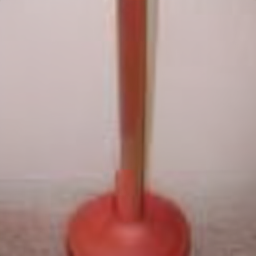

In [22]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=20, scale=3, keep_intermediates=True)
img

In [23]:
len(intermediates)

21

# WITH UPDATES!

In [79]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=20)


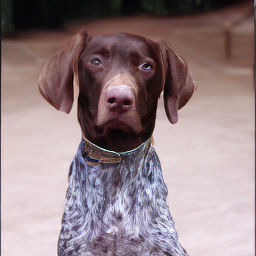

In [80]:
latent_to_img(teacher, intermediates[-1])

# Creating a dataset

In [16]:
dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
dataset_name = "teacher_128.pt"
make_dataset(teacher, sampler_teacher, 4, 128, dataset_path, dataset_name)

100%|██████████| 4/4 [00:41<00:00, 10.39s/it]


# With Updates and student Loss!

In [2]:
import copy

teacher = get_model(config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml", model_path=f"{cwd}/models/cin256_original.ckpt")
sampler_teacher = DDIMSampler(teacher)
student = copy.deepcopy(teacher)
student.requires_grad = True
sampler_student = DDIMSampler(student)

for param in sampler_student.model.parameters():
    param.requires_grad = True

for param in student.model.parameters():
    param.requires_grad = True

sampler_student.model.requires_grad = True
student.model.requires_grad = True



Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


100%|██████████| 3/3 [00:20<00:00,  6.71s/it, loss=0.00234]


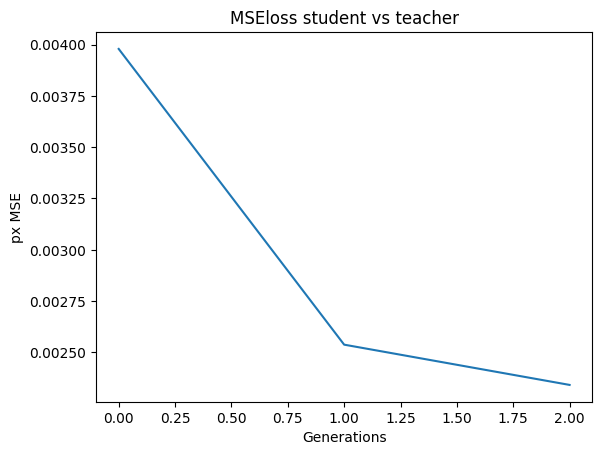

In [3]:
teacher_train_student(teacher, sampler_teacher, student, sampler_student, steps=20, generations=3)

# Train student from pre-generated teacher dataset

In [3]:
dataset_path = f"{cwd}/data/pre_generated/teacher_128/4_teacher_128.pt"
dataset = torch.load(dataset_path)

In [4]:
model = teacher
sampler = sampler_teacher

In [20]:
len(dataset)

4

In [ ]:
model, sampler, steps, lr=0.00000001, 

In [24]:
with tqdm.tqdm(range(len(dataset))) as tepoch:
        for i, _ in enumerate(tepoch):
            print(len(dataset[str(i)]))

100%|██████████| 4/4 [00:00<?, ?it/s]

2
2
2
2


In [6]:
def train_student_dataset(dataset, model, sampler, steps, lr=0.00000001):
    device = torch.device("cuda")
    for param in sampler.model.parameters():
        param.requires_grad = True

    for param in model.model.parameters():
        param.requires_grad = True
    MSEloss = nn.MSELoss()
    ddim_steps_student = steps
    STUDENT_STEPS = 1
    ddim_eta = 0.0
    scale = 3.0

    averaged_losses = []
    teacher_samples = list()

    optimizer = torch.optim.Adam(sampler.model.parameters(), lr=lr)

    with torch.no_grad():
        
        with model.ema_scope():
            uc = model.get_learned_conditioning({model.cond_stage_key: torch.tensor(1*[1000]).to(model.device)})

            with tqdm.tqdm(range(len(dataset))) as tepoch:
                    for i, _ in enumerate(tepoch):
                        class_prompt = dataset[str(i)]["class"]
                        losses = []
                        sampler.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                        xc = torch.tensor([class_prompt])
                        c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                        sampler.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                        c_student = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
                        
                        for steps, x_T in enumerate(dataset[str(i)]["intermediates"]):
                            
                            with torch.enable_grad():
                                optimizer.zero_grad()
                                x_T.requires_grad=True
                                
                                samples_ddim_student, student_intermediate, x_T_copy = sampler.sample_student(S=STUDENT_STEPS,
                                                                conditioning=c_student,
                                                                batch_size=1,
                                                                shape=[3, 64, 64],
                                                                verbose=False,
                                                                x_T=x_T,
                                                                unconditional_guidance_scale=scale,
                                                                unconditional_conditioning=uc, 
                                                                eta=ddim_eta,
                                                                keep_intermediates=False,
                                                                intermediate_step = steps*STUDENT_STEPS,
                                                                steps_per_sampling = STUDENT_STEPS,
                                                                total_steps = ddim_steps_student)
                                
                                x_T_student = student_intermediate["x_inter"][-1]
                                loss = MSEloss(x_T_student, x_T)
                                loss.backward()
                                optimizer.step()
                                x_T.detach()
                                losses.append(loss.item())

                    # print("Loss: ", round(sum(losses) / len(losses), 5), end= " - ")
                    averaged_losses.append(sum(losses) / len(losses))
                    tepoch.set_postfix(loss=averaged_losses[-1])
                                                                    
    plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
    plt.xlabel("Generations")
    plt.ylabel("px MSE")
    plt.title("MSEloss student vs teacher")
    plt.show()

train_student_dataset(dataset, model=teacher, sampler=sampler_teacher, steps=64, lr=0.00000001)

  0%|          | 0/4 [00:06<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [7]:
loss

NameError: name 'loss' is not defined

# Direct Comparison

## Teacher

In [24]:
x_T = None

NUM_CLASSES = 1000
inst_per_distil = 1
generations = 2
ddim_steps_teacher = 20
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.0
scale = 3.0

updates = int(ddim_steps_teacher / TEACHER_STEPS)

all_samples = list()
averaged_losses = []

teacher_samples = list()
student_samples = list()

In [1]:
with teacher.ema_scope():
    uc = teacher.get_learned_conditioning(
            {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)})
    with torch.no_grad():
        xc = torch.tensor([992])
        c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
        samples_ddim, _, x_T_copy = sampler_teacher.sample(S=6,
                                            conditioning=c,
                                            batch_size=1,
                                            x_T=None,
                                            shape=[3, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=scale,
                                            unconditional_conditioning=uc, 
                                            eta=ddim_eta)

x_samples_ddim = teacher.decode_first_stage(samples_ddim)
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

NameError: name 'teacher' is not defined

## Student

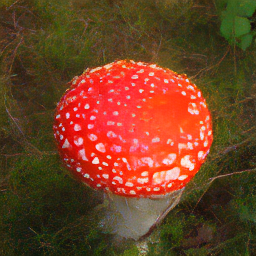

In [65]:
with student.ema_scope():
    uc = student.get_learned_conditioning(
            {student.cond_stage_key: torch.tensor(1*[1000]).to(student.device)})
    with torch.no_grad():
        xc = torch.tensor([992])
        c = student.get_learned_conditioning({student.cond_stage_key: xc.to(student.device)})
        samples_ddim, _, x_T_delete = sampler_student.sample(S=6,
                                            conditioning=c,
                                            batch_size=1,
                                            x_T=x_T_copy,
                                            shape=[3, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=scale,
                                            unconditional_conditioning=uc, 
                                            eta=ddim_eta)

x_samples_ddim = student.decode_first_stage(_["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

## Extra

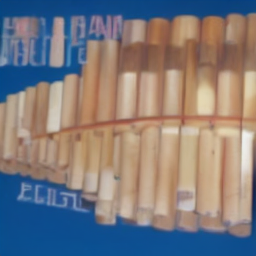

In [12]:
x_samples_ddim = teacher.decode_first_stage(teacher_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

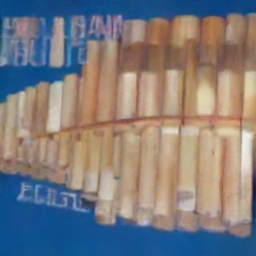

In [13]:
x_samples_ddim = student.decode_first_stage(student_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

In [ ]:
# state_teacher = sampler_teacher.model.state_dict().__str__()
# state_student = sampler_student.model.state_dict().__str__()

# print("sampler teacher equals student:", state_teacher == state_student)

# state_teacher = teacher.state_dict().__str__()
# state_student = student.state_dict().__str__()

# print("teacher equals student:", state_teacher == state_student)
# del state_teacher
# del state_student

sampler teacher equals student: True
teacher equals student: True


In [56]:
student.model.requires_grad = True
student.model.state_dict()["diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight"]

tensor([[ 0.0298, -0.0053,  0.0131,  ..., -0.0389,  0.0320,  0.0510],
        [ 0.0250,  0.0344, -0.0068,  ...,  0.0140,  0.0029, -0.0002],
        [ 0.0209, -0.0018, -0.0079,  ..., -0.0069, -0.0183, -0.0182],
        ...,
        [-0.0167,  0.0060, -0.0065,  ...,  0.0082,  0.0049, -0.0184],
        [-0.0073,  0.0075, -0.0094,  ..., -0.0135, -0.0248, -0.0059],
        [-0.0333,  0.0179,  0.0139,  ..., -0.0017,  0.0165,  0.0130]],
       device='cuda:0')

In [57]:
teacher.model.state_dict()["diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight"]

tensor([[ 0.0301, -0.0067,  0.0129,  ..., -0.0374,  0.0318,  0.0501],
        [ 0.0256,  0.0341, -0.0073,  ...,  0.0139,  0.0020, -0.0004],
        [ 0.0216, -0.0021, -0.0087,  ..., -0.0067, -0.0189, -0.0189],
        ...,
        [-0.0171,  0.0063, -0.0063,  ...,  0.0088,  0.0052, -0.0181],
        [-0.0076,  0.0068, -0.0104,  ..., -0.0135, -0.0250, -0.0060],
        [-0.0336,  0.0177,  0.0130,  ..., -0.0027,  0.0162,  0.0131]],
       device='cuda:0')

In [ ]:
grid = torch.stack(teacher_samples)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=inst_per_distil * 2)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

# That stuff not working, so saving images first:

In [ ]:
# import copy

# teacher = get_model(teacher=True)
# sampler_teacher = DDIMSampler(teacher)


In [ ]:
# import pandas as pd

# NUM_CLASSES = 1000
# generations = 1
# ddim_steps_teacher = 32
# TEACHER_STEPS = 2
# ddim_eta = 0.0
# scale = 3.0
# updates = int(ddim_steps_teacher / TEACHER_STEPS)

# all_samples = list()
# teacher_samples = list()

# classes = []
# conditioning = []
# intermediates = []
# x_ts = []

# with torch.no_grad():
#         with teacher.ema_scope():
#                 uc = teacher.get_learned_conditioning(
#                         {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
#                         )
#                 for class_prompt in torch.randint(0, NUM_CLASSES, (generations,)):

#                         sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
#                         xc = torch.tensor([class_prompt])
#                         c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
#                         x_T = None
                     
#                         for steps in range(updates):
                                
                                
#                                 # with torch.no_grad():
#                                 print("step:", steps)
                                
#                                 samples_ddim, teacher_intermediate, x_T_copy = sampler_teacher.sample(S=TEACHER_STEPS,
#                                                                 conditioning=c,
#                                                                 batch_size=1,
#                                                                 shape=[3, 64, 64],
#                                                                 verbose=False,
#                                                                 x_T=x_T,
#                                                                 unconditional_guidance_scale=scale,
#                                                                 unconditional_conditioning=uc, 
#                                                                 eta=ddim_eta,
#                                                                 keep_intermediates=True,
#                                                                 intermediate_step = steps*TEACHER_STEPS,
#                                                                 steps_per_sampling = TEACHER_STEPS,
#                                                                 total_steps = ddim_steps_teacher)
#                                 x_T = teacher_intermediate["x_inter"][-1]

#                                 x_ts.append(x_T_copy)
#                                 intermediates.append(x_T)
#                                 classes.append(xc)
#                                 conditioning.append(c)

#                                         with torch.enable_grad():
                                                
#                                                 if steps == 0:
                                                        
#                                                         x_T_student = copy.deepcopy(x_T_copy)
#                                                         x_T_student.requires_grad = True
                                                        
#                                                 optimizer.zero_grad()
#                                                 samples_ddim_student, student_intermediate, x_T_copy = sampler_student.sample_student(S=STUDENT_STEPS,
#                                                                                 conditioning=c_student,
#                                                                                 batch_size=1,
#                                                                                 shape=[3, 64, 64],
#                                                                                 verbose=False,
#                                                                                 x_T=x_T_student,
#                                                                                 unconditional_guidance_scale=scale,
#                                                                                 unconditional_conditioning=uc, 
#                                                                                 eta=ddim_eta,
#                                                                                 keep_intermediates=True,
#                                                                                 intermediate_step = steps*STUDENT_STEPS,
#                                                                                 steps_per_sampling = STUDENT_STEPS,
#                                                                                 total_steps = ddim_steps_student)
                                                
#                                                 x_T_student = student_intermediate["x_inter"][-1]
                                        
                                                
                                                
                                                
#                                                 # x_T_student.requires_grad = True
#                                                 # loss = mse_loss(x_T_student, x_T)
#                                                 loss = MSEloss(x_T_student, x_T)
#                                                 # loss = MSEloss(samples_ddim_student.flatten(), samples_ddim.flatten())
                                                
#                                                 print("Loss:", round(loss.item(), 5), end= " | ")
#                                                 print("loss", loss)
#                                                 print("backward!")
#                                                 loss.backward()
                                                
#                                                 optimizer.step()
                                                
#                                                 losses.append(loss.item())
#                                                 # optimizer.zero_grad()

In [ ]:
# torch.save(x_ts, "x_ts.pt")
# torch.save(classes, "classes.pt")
# torch.save(conditioning, "conditioning.pt")
# torch.save(intermediates, "intermediates.pt")

# Training student on saved images (fails for the same reason)

In [ ]:
student = get_model(teacher=False)
sampler_student = DDIMSampler(student)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/model_student.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [ ]:
# def mse_loss(teacher, student):
#     [b, c, h, w] = teacher.shape
#     size = c * h * w
#     teacher = teacher.flatten()
#     student = student.flatten()
#     return torch.sum((teacher - student) ** 2) / size

# MSEloss = nn.MSELoss()
# # torch.set_grad_enabled(True)
    

In [ ]:
# x_ts = torch.load("x_ts.pt")
# classes = torch.load("classes.pt")
# conditioning = torch.load("conditioning.pt")
# intermediates = torch.load("intermediates.pt")



In [ ]:
# NUM_CLASSES = 1000
# inst_per_distil = 1
# generations = 1
# ddim_steps_teacher = 32
# ddim_steps_student = 16
# TEACHER_STEPS = 2
# STUDENT_STEPS = 1
# ddim_eta = 0.0
# scale = 3.0

# updates = int(ddim_steps_teacher / TEACHER_STEPS)

# all_samples = list()
# averaged_losses = []

# teacher_samples = list()
# student_samples = list()

# losses = []

# optimizer = torch.optim.Adam(sampler_student.model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# # optimizer = torch.optim.SGD(sampler_student.model.parameters(), lr=0.0001, momentum=0.9)


# with torch.enable_grad():
#     with student.ema_scope():
#             uc = student.get_learned_conditioning(
#                     {student.cond_stage_key: torch.tensor(1*[1000]).to(student.device)}
#                     )
#             for i in range(len(classes)):
                    
#                     sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
#                     xc = torch.tensor([classes[i]])
#                     c = conditioning[i]
#                     for steps in range(16):
#                         optimizer.zero_grad()
                        
#                         x_T = x_ts[i]
#                         x_T.requires_grad = True
                            

                        
                                        

#                         samples_ddim_student, student_intermediate, x_T_copy = sampler_student.sample_student(S=STUDENT_STEPS,
#                                                 conditioning=c,
#                                                 batch_size=1,
#                                                 shape=[3, 64, 64],
#                                                 verbose=False,
#                                                 x_T=x_T,
#                                                 unconditional_guidance_scale=scale,
#                                                 unconditional_conditioning=uc, 
#                                                 eta=ddim_eta,
#                                                 keep_intermediates=True,
#                                                 intermediate_step = steps*STUDENT_STEPS,
#                                                 steps_per_sampling = STUDENT_STEPS,
#                                                 total_steps = ddim_steps_student)
                                
                        
                        
                                
                        
#                         loss = MSEloss(student_intermediate["x_inter"][-1], intermediates[i])                               
#                         print("Loss:", round(loss.item(), 5), end= " | ")
#                         print("loss", loss)
#                         print("backward!")
#                         loss.backward()
#                         optimizer.step()
#                         student_intermediate["x_inter"][-1].detach()
#                         losses.append(loss.item())
#                         # optimizer.zero_grad()
                
                            

#             print("Loss: ", round(sum(losses) / len(losses), 5), end= " - ")
#             averaged_losses.append(sum(losses) / len(losses))


#             x_samples_ddim = student.decode_first_stage(x_T)
#             x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
#             teacher_samples.append(x_samples_ddim)
                                            

# plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
# plt.xlabel("Generations")
# plt.ylabel("px MSE")
# plt.title("MSEloss student vs teacher")
# plt.show()

Loss: 7e-05 | loss tensor(7.4097e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
backward!
Loss: 1e-05 | loss tensor(1.3562e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
backward!


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

tensor([[[-3.0897e-01, -8.1357e-01, -4.6836e-01, -1.0647e-02,  5.6398e-01,
          -2.7529e-01, -8.6408e-01,  2.4275e-01,  3.1143e-01,  1.4782e+00,
          -2.7091e-01,  8.9683e-01, -1.1368e+00, -5.1967e-01,  5.1754e-02,
          -8.0823e-01, -5.4126e-01,  4.1333e-01, -1.8092e-01, -1.0548e+00,
           1.3068e+00,  2.5801e-02,  8.1891e-01, -7.3705e-01, -1.1790e+00,
           5.5735e-01,  1.5229e+00,  1.7481e-01, -5.5413e-02,  4.0618e-01,
          -7.4052e-01, -8.5432e-01,  5.5856e-01, -1.4511e-01,  1.0961e+00,
           1.1619e-01, -1.3935e-01,  6.0510e-02, -4.0981e-01, -4.8484e-01,
           4.3703e-01,  1.0501e-01, -3.3011e-01,  6.5664e-01, -4.3902e-01,
           1.3095e+00,  5.6454e-01, -1.1117e+00, -1.0756e+00,  4.0118e-01,
          -1.0922e+00, -8.2679e-01,  9.1757e-01, -9.3842e-01,  1.3343e-01,
          -1.2548e-01, -4.0816e-01, -1.0880e+00, -5.2834e-01, -3.8515e-01,
           4.5241e-01,  6.5101e-02,  4.2610e-01,  3.3078e-01, -8.5955e-01,
          -4.3450e-01, -1